# Task 1: One-to-one Training

In [4]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt


## Import model 

In [5]:
from FNO import FNO1d

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

## Training

### Import Data 

In [6]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
n_train = 1024 # number of training samples
n_val = 32
n_test = 256

# train dataset shape: (1024, 5, 128)
# 1024: number of trajectories
# 5: time snapthots of the solution: t= 0, 0.25, 0.5, 0.75, 1.0
# 128: spatial resolution of the data
train_dataset = torch.from_numpy(np.load("data/data_train_128.npy")).type(torch.float32)
test_dataset = torch.from_numpy(np.load("data/data_test_128.npy")).type(torch.float32)
# extract initial condition
u0_train = train_dataset[:, 0, :] 
u0_test = test_dataset[:, 0, :]
# extract solution at t=1.0
u1_train = train_dataset[:, -1, :]
u1_test = test_dataset[:, -1, :]

# Create grid coordinates
grid_size = u0_train.shape[1]  # 128
grid = torch.linspace(0, 1, grid_size).reshape(1, grid_size, 1)

# Add grid coordinates to input: shape (batch, spatial_points, 2)
u0_train_with_grid = torch.cat([u0_train.unsqueeze(-1), grid.repeat(u0_train.shape[0], 1, 1)], dim=-1)
u0_test_with_grid = torch.cat([u0_test.unsqueeze(-1), grid.repeat(u0_test.shape[0], 1, 1)], dim=-1)

# Move data to device
u0_train_with_grid = u0_train_with_grid.to(device)
u0_test_with_grid = u0_test_with_grid.to(device)
u1_train = u1_train.to(device)
u1_test = u1_test.to(device)

batch_size = 20

training_set = DataLoader(TensorDataset(u0_train_with_grid, u1_train), batch_size=batch_size, shuffle=True)
test_set = DataLoader(TensorDataset(u0_test_with_grid, u1_test), batch_size=batch_size, shuffle=False)

### Training Parameters

In [8]:
learning_rate = 0.001
epochs  = 250
step_size = 50
gamma = 0.5

In [ ]:
modes = 16
width = 64
fno = FNO1d(modes, width).to(device)  # model

optimizer = torch.optim.Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

### Training

In [ ]:
l = torch.nn.MSELoss()
freq_print = 1

for epoch in range(epochs):
    fno.train()
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()
    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(test_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(test_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


######### Epoch: 0  ######### Train Loss: 0.06737568619875954  ######### Relative L2 Test Norm: 20.67417390005929
######### Epoch: 1  ######### Train Loss: 0.008224352965883624  ######### Relative L2 Test Norm: 9.693331854684013
######### Epoch: 2  ######### Train Loss: 0.002027830959727558  ######### Relative L2 Test Norm: 4.693548883710589
######### Epoch: 3  ######### Train Loss: 0.0015433002537555206  ######### Relative L2 Test Norm: 4.76453127179827
######### Epoch: 4  ######### Train Loss: 0.0008228386600071994  ######### Relative L2 Test Norm: 3.92650260244097
######### Epoch: 5  ######### Train Loss: 0.0008192636269086506  ######### Relative L2 Test Norm: 7.1290499823434015
######### Epoch: 6  ######### Train Loss: 0.0010815622800482043  ######### Relative L2 Test Norm: 2.9132869924817766
######### Epoch: 7  ######### Train Loss: 0.00047332228831902076  ######### Relative L2 Test Norm: 4.366219248090472
######### Epoch: 8  ######### Train Loss: 0.0004828296243011629  ######### 

### Plot Results

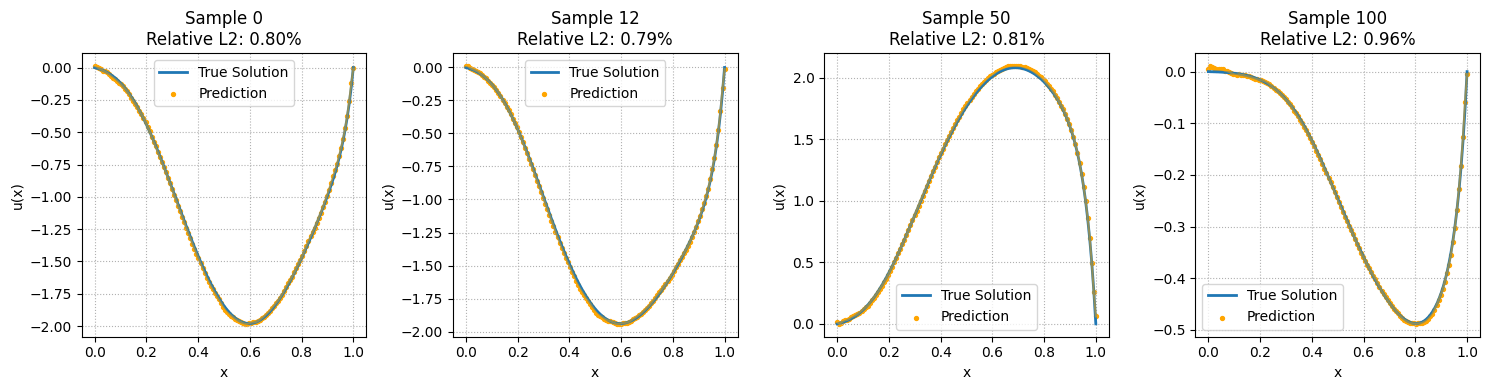

In [ ]:
# Select test samples to visualize
fno.eval()
with torch.no_grad():
    # Get a few test samples
    num_samples = 4
    idx_samples = [0, 12, 50, 100]  # Select different test samples
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    
    for i, idx_data in enumerate(idx_samples):
        # Get input and output for this sample
        input_sample = u0_test_with_grid[idx_data:idx_data+1]  # Shape: (1, 128, 2)
        output_true = u1_test[idx_data:idx_data+1]  # Shape: (1, 128)
        
        # Make prediction
        output_pred = fno(input_sample).squeeze(-1)  # Shape: (1, 128)
        
        # Extract grid coordinates for plotting (move to CPU)
        grid_coords = input_sample[0, :, 1].cpu().detach()  # x coordinates
        
        # Calculate error
        p = 2
        err = (torch.mean(abs(output_true - output_pred) ** p) / torch.mean(abs(output_true) ** p)) ** (1 / p) * 100
        
        # Plot (move tensors to CPU)
        ax = axes[i] if num_samples > 1 else axes
        ax.grid(True, which="both", ls=":")
        ax.plot(grid_coords, output_true[0].cpu().detach(), label="True Solution", c="C0", lw=2)
        ax.scatter(grid_coords, output_pred[0].cpu().detach(), label="Prediction", s=8, c="orange")
        ax.plot(grid_coords, output_pred[0].cpu().detach(), color="orange", alpha=0.5)
        ax.set_title(f"Sample {idx_data}\nRelative L2: {err.item():.2f}%")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# save the trained model
model_path = "fno_1d_model.pth"
# torch.save(fno.state_dict(), model_path)